In [13]:
import os
import shutil
import pandas as pd
from rdkit import Chem

main_dir = os.getcwd()
score_file = os.path.join(main_dir, "outputs/7FIN/score.dat")
sdf_dir = os.path.join(main_dir, "outputs/7FIN/")
output_dir = os.path.join(main_dir, "top_ligands")
os.makedirs(output_dir, exist_ok=True)

# 步骤1：读取分数文件，提取前5名配体（保留原始ID和分数）
df = pd.read_csv(score_file, sep='\t', comment='#', header=None, names=['ligand', 'score'])
df['ligand_id'] = df['ligand'].str.rsplit('-', n=1).str[0]  # 去除末尾的"-数字"
top_ligands = df.sort_values('score', ascending=False).head(100)

# 步骤2：遍历.sdf文件，匹配高分配体
results = []
for _, row in top_ligands.iterrows():
    ligand_full_id = row['ligand']  # 原始ID（如"XXX-N-0"）
    ligand_id = row['ligand_id']    # 去除末尾的ID（如"XXX-N"）
    score = row['score']
    
    # 查找匹配的.sdf文件（支持模糊匹配）
    matched_sdf = None
    for sdf_file in os.listdir(sdf_dir):
        if ligand_id in sdf_file and sdf_file.endswith('.sdf'):
            matched_sdf = sdf_file
            break
    
    if matched_sdf:
        # 复制.sdf文件到新文件夹
        src_path = os.path.join(sdf_dir, matched_sdf)
        dst_path = os.path.join(output_dir, matched_sdf)
        shutil.copy2(src_path, dst_path)
        
        # 提取SMILES
        mol = Chem.MolFromMolFile(src_path)
        smiles = Chem.MolToSmiles(mol) if mol else "SMILES解析失败"
        
        # 记录结果
        results.append({
            'ligand_name': matched_sdf.replace('.sdf', ''),
            'smiles': smiles,
            'score': score
        })

# 步骤3：生成CSV文件
csv_path = os.path.join(main_dir, "top_ligands_summary.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)

print(f"✅ 已完成！\n- 筛选的.sdf文件已保存到: {output_dir}\n- CSV汇总表已生成: {csv_path}")

✅ 已完成！
- 筛选的.sdf文件已保存到: /home/aidd/CarsiDock/top_ligands
- CSV汇总表已生成: /home/aidd/CarsiDock/top_ligands_summary.csv


In [18]:
dup_csv_path = "dup.csv"  # 原始CSV路径
if os.path.exists(dup_csv_path):
    # 读取原始CSV，提取SMILES和ID的映射（合并两列SMILES）
    dup_df = pd.read_csv(dup_csv_path)
    id_map = {}
    for _, row in dup_df.iterrows():
        if pd.notna(row['SMILES_7v35']):
            id_map[row['SMILES_7v35']] = row['ID']
        if pd.notna(row['SMILES_7vbh']):
            id_map[row['SMILES_7vbh']] = row['ID']
    
    # 将原始ID添加到结果中
    for entry in results:
        entry['ID'] = id_map.get(entry['smiles'], "N/A")
else:
    print("⚠️ 未找到 dup.csv，跳过原始ID合并")
    for entry in results:
        entry['original_id'] = "N/A"

# 生成最终的CSV（包含original_id列）
final_columns = ['ID', 'ligand_name', 'smiles', 'score']
pd.DataFrame(results)[final_columns].to_csv("top_ligands_summary.csv", index=False)

In [17]:
import os

# 获取当前目录下所有 .sdf 文件
sdf_files = [f for f in os.listdir() if f.endswith('.sdf')]

# 筛选出高分对应的 .sdf 文件
matched_files = []
for ligand_id in top_ligands:
    for f in sdf_files:
        if ligand_id in f:
            matched_files.append(f)
            break  # 假设每个 ID 只有一个对应文件

print("匹配到的 .sdf 文件:", matched_files)

匹配到的 .sdf 文件: []


In [2]:
import pandas as pd
import glob

# 获取当前目录下的所有 *_combined_score.dat 文件
file_list = glob.glob('*_combined_score.dat')

# 存储所有数据的列表
data_frames = []

for file in file_list:
    # 提取前缀（如 BA、CA）
    prefix = file.split('_')[0]
    
    # 读取文件，跳过注释行
    df = pd.read_csv(file, sep='\t', comment='#', header=None, names=['id', 'score'])
    
    # 处理 ID，只保留 "-" 前面的部分
    df['id'] = df['id'].str.split('-').str[0]
    
    # 添加一列标识来源（如 BA、CA）
    df['source'] = prefix
    
    # 添加到列表
    data_frames.append(df)

# 合并所有 DataFrame（纵向堆叠）
combined_df = pd.concat(data_frames, ignore_index=True)

# 保存为 CSV
combined_df.to_csv('A_scores.csv', index=False)

print("合并完成！结果保存")

合并完成！结果保存


合并后的 DataFrame 前 5 行：
                 id      Carsi  karma_score_aligned
0  ZINC001549159156  20.351570            18.815521
1  ZINC000225149067   8.602707            17.402534
2  ZINC000257218664  12.375223            16.251768
3  ZINC000257233104  10.406767            15.507822
4  ZINC000257209050  14.403154            18.731071


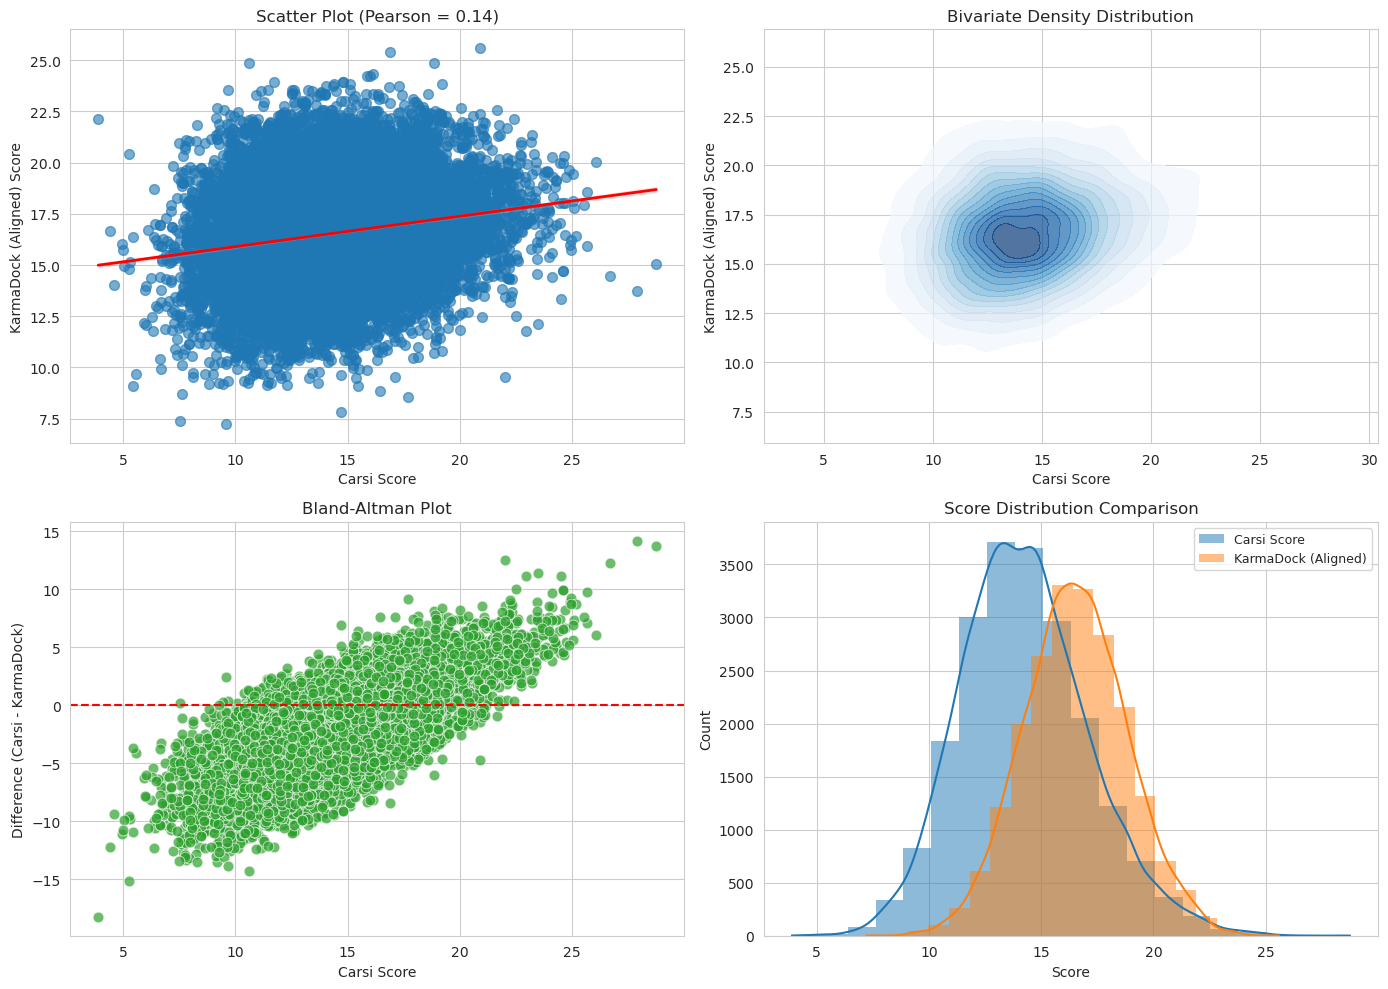

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# 1. 读取数据
# (1) CarsiDock 分数表
df_carsi = pd.read_csv("A_carsi_scores.csv")  # 列: id, score, source
df_carsi = df_carsi.rename(columns={"score": "Carsi"})       # 重命名 score 列为 Carsi
df_carsi = df_carsi[["id", "Carsi"]]                        # 只保留 id 和 Carsi 列

# (2) KarmaDock 分数表（使用对齐后的分数 karma_score_aligned）
df_karma = pd.read_csv("A_karma_scores.csv")          # 列: pdb_id, karma_score, karma_score_aligned, ...
df_karma["id"] = df_karma["pdb_id"].str.split("-").str[0]
df_karma = df_karma[["id", "karma_score_aligned"]]          # 只保留 id 和 karma_score_aligned 列

# 2. 合并两个表（内连接，仅保留共有的分子）
merged_df = pd.merge(
    df_carsi,
    df_karma,
    on="id",
    how="inner"
)

# 检查结果
print("合并后的 DataFrame 前 5 行：")
print(merged_df.head())

# 设置绘图风格
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# --------------------------
# 1. 散点图 + 线性回归拟合
# --------------------------
plt.subplot(2, 2, 1)
ax = sns.regplot(
    data=merged_df,
    x="Carsi",
    y="karma_score_aligned",
    scatter_kws={"s": 50, "alpha": 0.6, "color": "#1f77b4"},
    line_kws={"color": "red", "lw": 2}
)
plt.title(f"Scatter Plot (Pearson = {pearson_corr:.2f})", fontsize=12)
plt.xlabel("Carsi Score", fontsize=10)
plt.ylabel("KarmaDock (Aligned) Score", fontsize=10)

# --------------------------
# 2. 双变量核密度估计（KDE）
# --------------------------
plt.subplot(2, 2, 2)
sns.kdeplot(
    data=merged_df,
    x="Carsi",
    y="karma_score_aligned",
    cmap="Blues",
    fill=True,
    levels=15,  # 避免使用 thresh 参数
    alpha=0.7
)
plt.title("Bivariate Density Distribution", fontsize=12)
plt.xlabel("Carsi Score", fontsize=10)
plt.ylabel("KarmaDock (Aligned) Score", fontsize=10)

# --------------------------
# 3. Bland-Altman 图（一致性检验）
# --------------------------
plt.subplot(2, 2, 3)
merged_df["score_diff"] = merged_df["Carsi"] - merged_df["karma_score_aligned"]
sns.scatterplot(
    data=merged_df,
    x="Carsi",
    y="score_diff",
    s=60,
    alpha=0.7,
    color="#2ca02c"
)
plt.axhline(y=0, color="red", linestyle="--", lw=1.5)
plt.title("Bland-Altman Plot", fontsize=12)
plt.xlabel("Carsi Score", fontsize=10)
plt.ylabel("Difference (Carsi - KarmaDock)", fontsize=10)

# --------------------------
# 4. 分数分布直方图（分开绘制避免 KDE 冲突）
# --------------------------
plt.subplot(2, 2, 4)
# Carsi 分数分布
sns.histplot(
    data=merged_df,
    x="Carsi",
    color="#1f77b4",
    label="Carsi Score",
    kde=True,
    alpha=0.5,
    bins=20,
    edgecolor="none"
)
# KarmaDock 分数分布
sns.histplot(
    data=merged_df,
    x="karma_score_aligned",
    color="#ff7f0e",
    label="KarmaDock (Aligned)",
    kde=True,
    alpha=0.5,
    bins=20,
    edgecolor="none"
)
plt.title("Score Distribution Comparison", fontsize=12)
plt.xlabel("Score", fontsize=10)
plt.legend(fontsize=9)

plt.tight_layout()
plt.savefig("Carsi_vs_KarmaDock_aligned.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
corr, p_value = spearmanr(merged_df["Carsi"], merged_df["karma_score_aligned"])
print(f"Spearman相关系数: {corr:.3f} (p值: {p_value:.3g})")

Spearman相关系数: 0.177 (p值: 5.52e-148)


In [10]:
# 将两列分数分别分为4个分位数组（Q1-Q4）
merged_df["Carsi_rank"] = pd.qcut(merged_df["Carsi"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
merged_df["Karma_rank"] = pd.qcut(merged_df["karma_score_aligned"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# 交叉表统计
cross_tab = pd.crosstab(merged_df["Carsi_rank"], merged_df["Karma_rank"], normalize="index")
print(cross_tab)

Karma_rank        Q1        Q2        Q3        Q4
Carsi_rank                                        
Q1          0.337948  0.247866  0.219799  0.194386
Q2          0.273469  0.255832  0.238195  0.232505
Q3          0.232549  0.257967  0.252656  0.256829
Q4          0.156078  0.238384  0.289209  0.316328


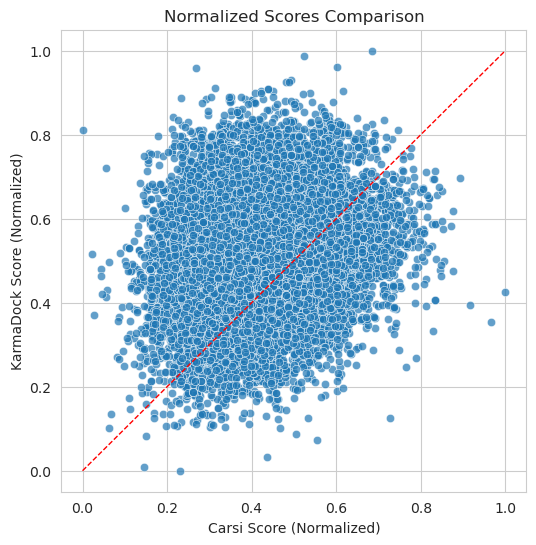

In [29]:
# 标准化
merged_df["Carsi_norm"] = (merged_df["Carsi"] - merged_df["Carsi"].min()) / (merged_df["Carsi"].max() - merged_df["Carsi"].min())
merged_df["Karma_norm"] = (merged_df["karma_score_aligned"] - merged_df["karma_score_aligned"].min()) / (merged_df["karma_score_aligned"].max() - merged_df["karma_score_aligned"].min())

# 绘图
plt.figure(figsize=(6, 6))
sns.scatterplot(data=merged_df, x="Carsi_norm", y="Karma_norm", alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', lw=1)  # 添加对角线参考线
plt.title("Normalized Scores Comparison")
plt.xlabel("Carsi Score (Normalized)")
plt.ylabel("KarmaDock Score (Normalized)")
plt.savefig("Carsi_vs_KarmaDock_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

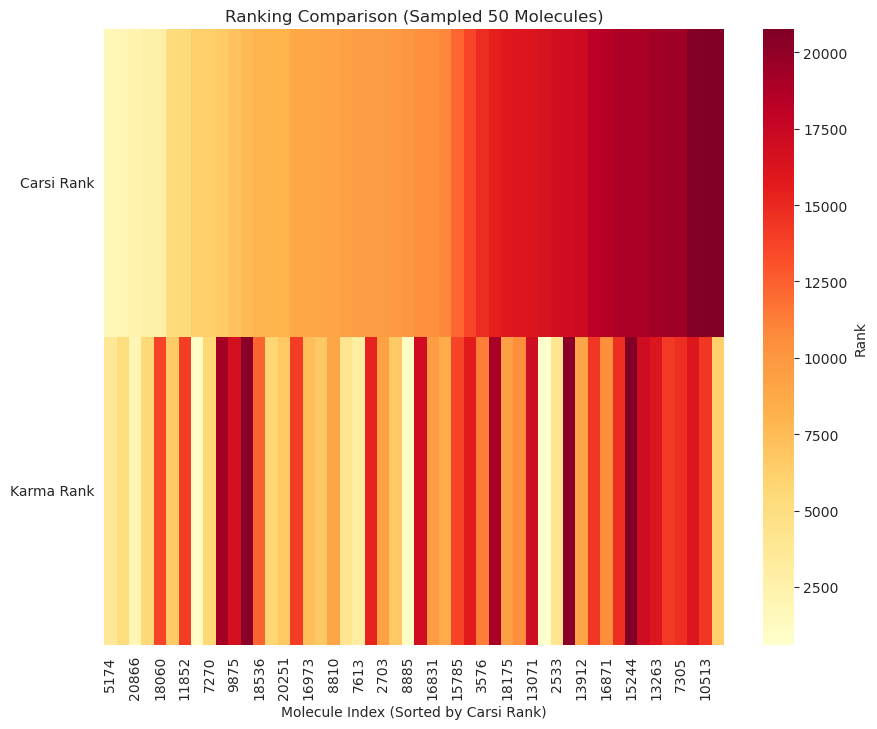

In [12]:
# 计算排名
merged_df["Carsi_rank"] = merged_df["Carsi"].rank()
merged_df["Karma_rank"] = merged_df["karma_score_aligned"].rank()

# 选择部分分子展示（避免过多数据点）
sample_df = merged_df.sample(50, random_state=42).sort_values("Carsi_rank")

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(
    sample_df[["Carsi_rank", "Karma_rank"]].T,
    cmap="YlOrRd",
    annot=False,
    cbar_kws={"label": "Rank"}
)
plt.title("Ranking Comparison (Sampled 50 Molecules)")
plt.xlabel("Molecule Index (Sorted by Carsi Rank)")
plt.yticks([0.5, 1.5], ["Carsi Rank", "Karma Rank"], rotation=0)
plt.show()

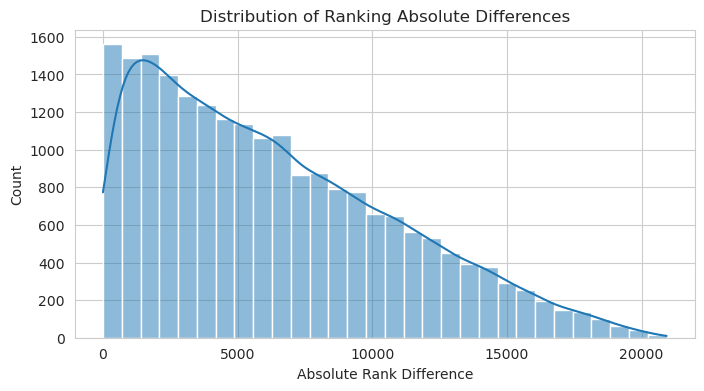

In [13]:
merged_df["rank_diff"] = (merged_df["Carsi_rank"] - merged_df["Karma_rank"]).abs()

plt.figure(figsize=(8, 4))
sns.histplot(data=merged_df, x="rank_diff", bins=30, kde=True)
plt.title("Distribution of Ranking Absolute Differences")
plt.xlabel("Absolute Rank Difference")
plt.ylabel("Count")
plt.show()

In [14]:
def check_extreme_overlap(df, col1, col2, n=5):
    """检查一列的Top/Bottom N分子在另一列中的排名"""
    # 获取col1的Top N和Bottom N分子
    top_col1 = df.nlargest(n, col1)[["id", col1, col2]]
    bottom_col1 = df.nsmallest(n, col1)[["id", col1, col2]]
    
    # 计算这些分子在col2中的排名百分比
    top_col1[f"{col2}_rank_pct"] = top_col1[col2].rank(pct=True).round(2)
    bottom_col1[f"{col2}_rank_pct"] = bottom_col1[col2].rank(pct=True).round(2)
    
    return {
        f"{col1}的Top {n}在{col2}中的排名分布": top_col1,
        f"{col1}的Bottom {n}在{col2}中的排名分布": bottom_col1
    }

# 检查Top/Bottom 5分子
overlap_stats = check_extreme_overlap(merged_df, "Carsi", "karma_score_aligned", n=5)
for title, data in overlap_stats.items():
    print(f"\n{title}:")
    print(data.to_string(index=False))


Carsi的Top 5在karma_score_aligned中的排名分布:
              id     Carsi  karma_score_aligned  karma_score_aligned_rank_pct
ZINC000034743444 28.752876            15.051771                           0.6
ZINC000022927754 27.895581            13.721325                           0.2
ZINC000068604143 26.692839            14.468491                           0.4
ZINC000016385649 26.088355            20.033298                           1.0
ZINC000005602219 25.670715            15.952731                           0.8

Carsi的Bottom 5在karma_score_aligned中的排名分布:
              id    Carsi  karma_score_aligned  karma_score_aligned_rank_pct
ZINC000005543374 3.895233            22.141420                           1.0
ZINC000004684261 4.442586            16.682058                           0.8
ZINC000104196606 4.590731            14.010211                           0.2
ZINC000017105356 4.953097            16.035965                           0.6
ZINC000001586853 4.997872            15.745903                  

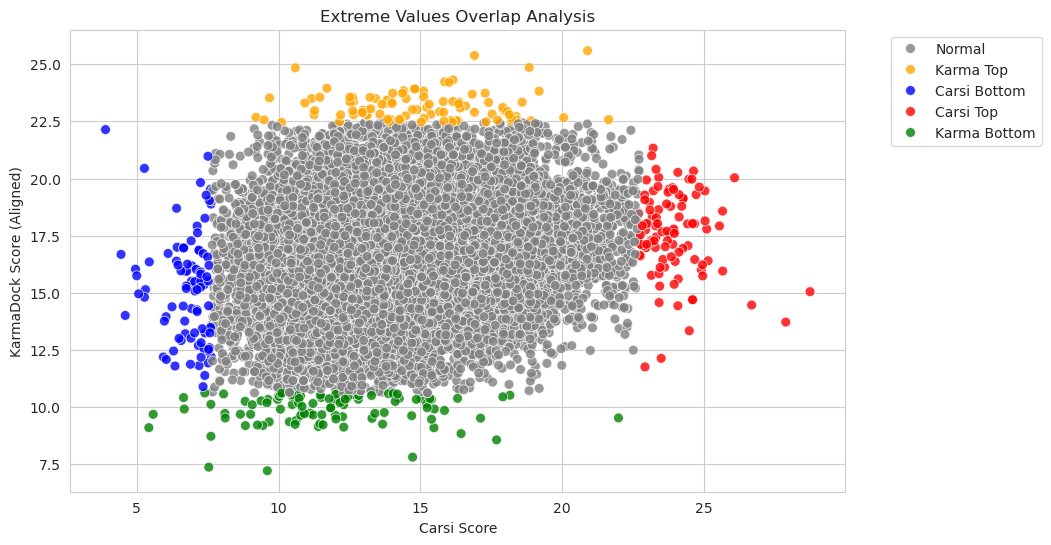

In [30]:
# 标记Top/Bottom N分子
n = 100
merged_df["extreme_group"] = "Normal"
merged_df.loc[merged_df["Carsi"].isin(merged_df["Carsi"].nlargest(n).values), "extreme_group"] = "Carsi Top"
merged_df.loc[merged_df["Carsi"].isin(merged_df["Carsi"].nsmallest(n).values), "extreme_group"] = "Carsi Bottom"
merged_df.loc[merged_df["karma_score_aligned"].isin(merged_df["karma_score_aligned"].nlargest(n).values), "extreme_group"] = "Karma Top"
merged_df.loc[merged_df["karma_score_aligned"].isin(merged_df["karma_score_aligned"].nsmallest(n).values), "extreme_group"] = "Karma Bottom"

# 绘制散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_df,
    x="Carsi",
    y="karma_score_aligned",
    hue="extreme_group",
    palette={"Normal": "gray", "Carsi Top": "red", "Carsi Bottom": "blue", "Karma Top": "orange", "Karma Bottom": "green"},
    s=50,
    alpha=0.8
)
plt.title("Extreme Values Overlap Analysis")
plt.xlabel("Carsi Score")
plt.ylabel("KarmaDock Score (Aligned)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Carsi_vs_KarmaDock_extreme.png", dpi=300, bbox_inches="tight")
plt.show()


In [18]:
import pandas as pd

# 加载Boltz2数据 (1000个样本)
df_boltz2 = pd.read_csv("4bvc_boltz2_results.csv")  # 列: id, zinc_id, affinity_probability_binary
df_boltz2["id"] = df_boltz2["zinc_id"].str.split("-").str[0]  # 统一ID格式（去掉-后缀）

# 加载Carsi和KarmaDock数据 (假设已处理为merged_df，包含id, Carsi, karma_score_aligned)
# merged_df = pd.read_csv("merged_carsi_karma.csv")  

# 合并三个模型的数据
df_combined = pd.merge(
    df_boltz2[["id", "affinity_probability_binary"]],
    merged_df[["id", "Carsi", "karma_score_aligned"]],
    on="id",
    how="inner"  # 仅保留三模型共有的分子
)

print(f"合并后共有 {len(df_combined)} 个分子")
print(df_combined.head())

合并后共有 1374 个分子
                 id  affinity_probability_binary      Carsi  \
0  ZINC000239378254                     0.518121  14.634904   
1  ZINC000019950262                     0.665317  16.618792   
2  ZINC000019950262                     0.665317  16.609457   
3  ZINC000017204113                     0.613946  13.553809   
4  ZINC000017204113                     0.613946  13.553809   

   karma_score_aligned  
0            17.162245  
1            15.687035  
2            15.687035  
3            17.202366  
4            17.202366  


In [19]:
# 计算描述性统计
print(df_combined.describe())

# 检查Boltz2的二元分类分布
print("\nBoltz2分类分布:")
print(df_combined["affinity_probability_binary"].apply(lambda x: "High" if x > 0.5 else "Low").value_counts())

       affinity_probability_binary        Carsi  karma_score_aligned
count                  1374.000000  1374.000000          1374.000000
mean                      0.475200    14.172705            16.448829
std                       0.174472     2.892534             2.273443
min                       0.128827     6.104039             8.567387
25%                       0.335308    12.176220            15.027823
50%                       0.457566    13.946717            16.476645
75%                       0.592475    15.996969            17.992531
max                       0.966985    24.446158            23.371170

Boltz2分类分布:
affinity_probability_binary
Low     783
High    591
Name: count, dtype: int64


In [20]:
from scipy.stats import spearmanr

# Boltz2与Carsi/KarmaDock的Spearman相关系数
corr_carsi, _ = spearmanr(df_combined["affinity_probability_binary"], df_combined["Carsi"])
corr_karma, _ = spearmanr(df_combined["affinity_probability_binary"], df_combined["karma_score_aligned"])

print(f"\nSpearman相关系数:")
print(f"- Boltz2 vs Carsi: {corr_carsi:.3f}")
print(f"- Boltz2 vs KarmaDock: {corr_karma:.3f}")


Spearman相关系数:
- Boltz2 vs Carsi: 0.131
- Boltz2 vs KarmaDock: -0.035


In [21]:
# 定义Boltz2高/低分类（阈值=0.5）
df_combined["boltz2_class"] = df_combined["affinity_probability_binary"].apply(lambda x: "High" if x > 0.5 else "Low")

# 定义Carsi/KarmaDock高/低分类（按中位数分）
df_combined["carsi_class"] = df_combined["Carsi"].apply(lambda x: "High" if x > df_combined["Carsi"].median() else "Low")
df_combined["karma_class"] = df_combined["karma_score_aligned"].apply(lambda x: "High" if x > df_combined["karma_score_aligned"].median() else "Low")

# 计算分类一致率
carsi_agreement = (df_combined["boltz2_class"] == df_combined["carsi_class"]).mean()
karma_agreement = (df_combined["boltz2_class"] == df_combined["karma_class"]).mean()

print(f"\n分类一致率（与Boltz2相比）:")
print(f"- Carsi: {carsi_agreement:.1%}")
print(f"- KarmaDock: {karma_agreement:.1%}")


分类一致率（与Boltz2相比）:
- Carsi: 56.0%
- KarmaDock: 48.0%


In [22]:
# 找出Boltz2高但Carsi/KarmaDock低的分子（潜在假阴性）
false_negatives = df_combined[
    (df_combined["boltz2_class"] == "High") & 
    ((df_combined["carsi_class"] == "Low") | (df_combined["karma_class"] == "Low"))
]

print(f"\n潜在假阴性分子（Boltz2高但其他模型低）: {len(false_negatives)} 个")
print(false_negatives[["id", "affinity_probability_binary", "Carsi", "karma_score_aligned"]].head())


潜在假阴性分子（Boltz2高但其他模型低）: 416 个
                 id  affinity_probability_binary      Carsi  \
1  ZINC000019950262                     0.665317  16.618792   
2  ZINC000019950262                     0.665317  16.609457   
3  ZINC000017204113                     0.613946  13.553809   
4  ZINC000017204113                     0.613946  13.553809   
6  ZINC000004721249                     0.666250  13.919952   

   karma_score_aligned  
1            15.687035  
2            15.687035  
3            17.202366  
4            17.202366  
6            15.007414  


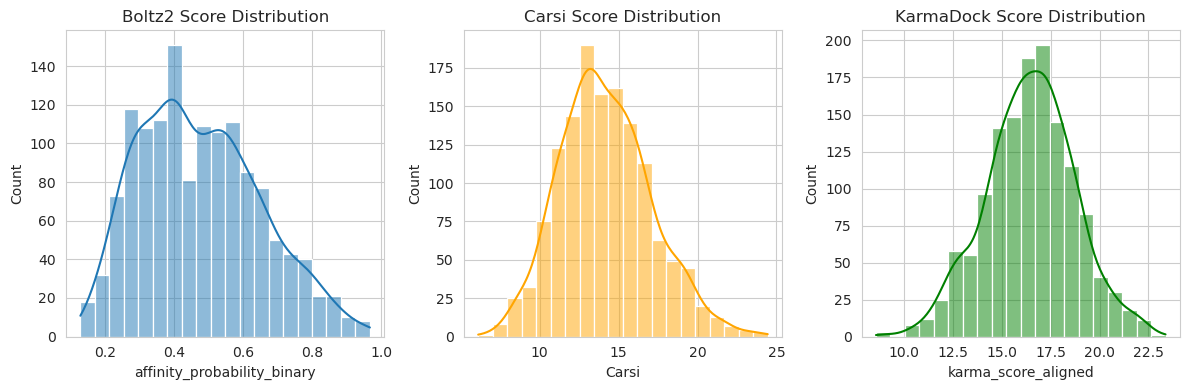

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df_combined["affinity_probability_binary"], bins=20, kde=True)
plt.title("Boltz2 Score Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df_combined["Carsi"], bins=20, kde=True, color="orange")
plt.title("Carsi Score Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df_combined["karma_score_aligned"], bins=20, kde=True, color="green")
plt.title("KarmaDock Score Distribution")
plt.tight_layout()
plt.savefig("distribution.png", dpi=300, bbox_inches="tight")
plt.show()

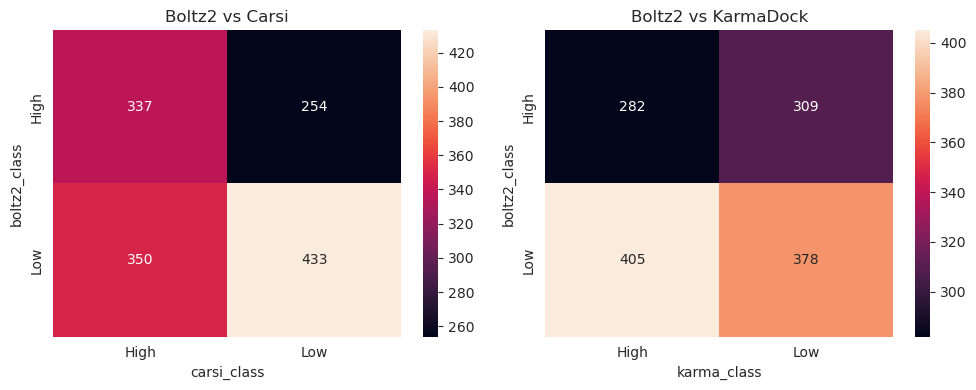

In [32]:
# 交叉表：Boltz2 vs Carsi/KarmaDock
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pd.crosstab(df_combined["boltz2_class"], df_combined["carsi_class"]), annot=True, fmt="d")
plt.title("Boltz2 vs Carsi")

plt.subplot(1, 2, 2)
sns.heatmap(pd.crosstab(df_combined["boltz2_class"], df_combined["karma_class"]), annot=True, fmt="d")
plt.title("Boltz2 vs KarmaDock")
plt.tight_layout()
plt.savefig("crosstab.png", dpi=300, bbox_inches="tight")
plt.show()

In [25]:
# 计算每个分子的排名百分位
df_combined["boltz2_rank_pct"] = df_combined["affinity_probability_binary"].rank(pct=True)
df_combined["carsi_rank_pct"] = df_combined["Carsi"].rank(pct=True)
df_combined["karma_rank_pct"] = df_combined["karma_score_aligned"].rank(pct=True)

# 统计排名百分位差异
df_combined["rank_diff_max"] = df_combined[["boltz2_rank_pct", "carsi_rank_pct", "karma_rank_pct"]].max(axis=1) - \
                              df_combined[["boltz2_rank_pct", "carsi_rank_pct", "karma_rank_pct"]].min(axis=1)
print(f"最大排名百分位差异 >0.5的分子数: {(df_combined['rank_diff_max'] > 0.5).sum()}")

最大排名百分位差异 >0.5的分子数: 637


TypeError: 'value' must be an instance of str or bytes, not a numpy.float64

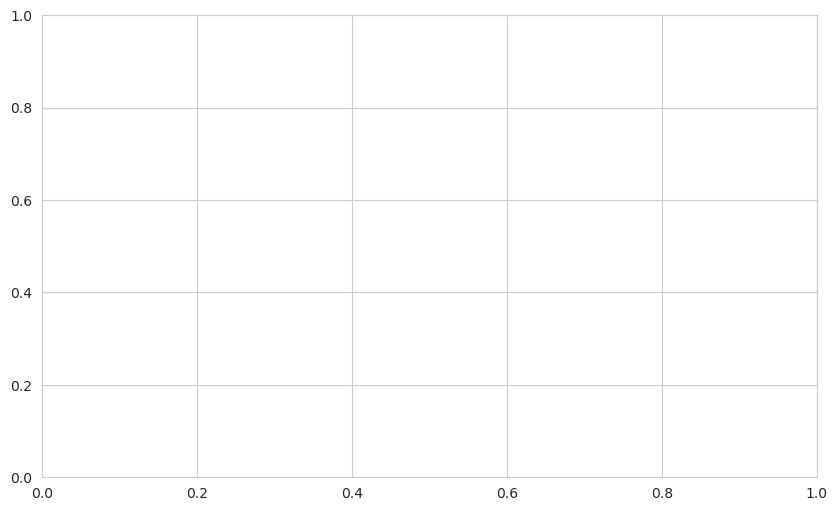

In [27]:
from pandas.plotting import parallel_coordinates

# 计算排名百分位
df_rank = df_combined[["id", "boltz2_rank_pct", "carsi_rank_pct", "karma_rank_pct"]].melt(id_vars="id", var_name="model", value_name="rank_pct")

# 绘制平行坐标图
plt.figure(figsize=(10, 6))
parallel_coordinates(
    df_rank.sample(100, random_state=42),  # 随机采样100个分子避免过载
    class_column="model",
    colormap="viridis",
    alpha=0.5
)
plt.title("Rank Percentile Across Models (Sampled 100 Molecules)")
plt.ylabel("Rank Percentile (0=Lowest, 1=Highest)")
plt.xticks(rotation=45)
plt.show()

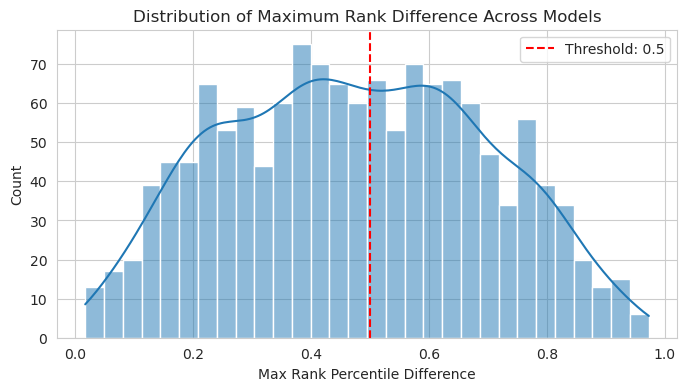

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df_combined, x="rank_diff_max", bins=30, kde=True)
plt.title("Distribution of Maximum Rank Difference Across Models")
plt.xlabel("Max Rank Percentile Difference")
plt.axvline(x=0.5, color="red", linestyle="--", label="Threshold: 0.5")
plt.legend()
plt.show()